In [1]:
# !pip install tf_keras tensorflow tensorflow-recommenders tensorflow-datasets scann

In [2]:
# Use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [3]:
from typing import Dict, Text

import keras
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

RANDOM_STATE = 42

tf.random.set_seed(RANDOM_STATE)

2024-08-27 16:23:12.743776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 16:23:12.768161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 16:23:12.774584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 16:23:12.794288: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 16:23:13.977303: W tensorflow/compiler/tf2

## Preprocess

### Download Datasets

In [4]:
# Download the dataset and cache them as `tfrecord`

ratings_dataset, ratings_dataset_info = tfds.load(
    # Options: '25m-ratings', 'latest-small-ratings', '100k-ratings', '1m-ratings', '20m-ratings'
    name = 'movielens/100k-ratings',
    # MovieLense has only the `train` split.
    split = 'train',
    # Include metadata like version, description, homepage, citation, etc.
    with_info = True
)

movies_dataset, movies_dataset_info = tfds.load(
    # Options: '25m-movies', 'latest-small-movies', '100k-movies', '1m-movies', '20m-movies'
    name = 'movielens/100k-movies',
    # MovieLense has only the `train` split.
    split = 'train',
    # Include metadata like version, description, homepage, citation, etc.
    with_info = True
)

I0000 00:00:1724763196.220627   85702 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724763196.304123   85702 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724763196.304308   85702 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724763196.310941   85702 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724763196.311172   85702 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

### Feature Selection

In [5]:
# Feature selection
ratings_dataset = ratings_dataset.map(
    lambda rating: {
        # `user_id` is useful as a user identifier.
        'user_id': rating['user_id'],
        # `movie_id` is useful as a movie identifier.
        'movie_id': rating['movie_id'],
        # `movie_title` is useful as a textual information about the movie.
        'movie_title': rating['movie_title'],
        # `user_rating` shows the user's level of interest to a movie.
        'user_rating': rating['user_rating'],
        # `timestamp` will allow us to model the effect of time.
        'timestamp': rating['timestamp']
    }
)

### Dataset Splitting

In [6]:
# Shuffle the elements of the dataset randomly.
ratings_dataset_shuffled = ratings_dataset.shuffle(
    # The new dataset will be sampled from a buffer window of first `buffer_size`
    # elements of the dataset
    buffer_size = 100_000,
    # The random seed used to create the distribution.
    seed = RANDOM_STATE,
    # `list(dataset.as_numpy_iterator()` yields different result for each call
    # Because reshuffle_each_iteration defaults to True.
    reshuffle_each_iteration = False
)

# Split dataset randomly (80% for training and 20% for validation)
trainset_size: int  = 0.2 * ratings_dataset.__len__().numpy()

ratings_trainset = ratings_dataset_shuffled.take(trainset_size)
print(f"trainset_size:", ratings_trainset.__len__().numpy())

ratings_validset = ratings_dataset_shuffled.skip(trainset_size)
print(f"validset_size:", ratings_validset.__len__().numpy())

trainset_size: 20000
validset_size: 80000


### Categorical Features to Embeddings

In [7]:
USER_ID_EMBEDDING_DIM = 32

# Make a Keras StringLookup layer as the mapping (lookup)
user_id_lookup_layer = tf.keras.layers.StringLookup(
    mask_token = None,
    # Include the OOV token so the layer can handle categorical values 
    # that are not in the vocabulary and the model can continue to learn 
    # and make recommendations even using features it has not been seen 
    # during vocabulary construction.
    oov_token = "[UNK]",
)

# StringLookup layer is a non-trainable layer and its state (the vocabulary)
# must be constructed and set before training in a step called "adaptation".
user_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['user_id']
    )
)

user_ids            = ['1', '124', 'xxx']
user_ids_mappings   = list(user_id_lookup_layer(['1', '12', '100', 'xxx']).numpy())
print(f"Lookups for user_ids {user_ids} -> {user_ids_mappings}")


user_id_embedding_layer = tf.keras.layers.Embedding(
    # Size of the vocabulary
    input_dim = user_id_lookup_layer.vocabulary_size(),
    # Dimension of the dense embedding
    output_dim = USER_ID_EMBEDDING_DIM
)

# A model that takes raw string feature values (user_id) in and yields embeddings
user_id_model = tf.keras.Sequential(
    [
        user_id_lookup_layer,
        user_id_embedding_layer
    ]
)

user_ids_embeddings = user_id_model(tf.convert_to_tensor(user_ids))
print(f"Embeddings for user_ids {user_ids} -> {user_ids_embeddings}")

Lookups for user_ids ['1', '124', 'xxx'] -> [65, 555, 408, 0]
Embeddings for user_ids ['1', '124', 'xxx'] -> [[-0.02444352 -0.01522372 -0.02658457  0.02106227 -0.00209454  0.0101514
   0.01054169  0.02724786  0.04612948  0.04093715 -0.04140062 -0.01141364
   0.040016   -0.00546493 -0.00183631 -0.01695003  0.01730149  0.02019521
  -0.00603181  0.0417619  -0.03045115  0.04539082 -0.02178631  0.01496513
  -0.03336133  0.03876824 -0.00398767  0.03948392  0.03030792  0.04763569
   0.00172392  0.00495978]
 [-0.01337718  0.04346332  0.02053157  0.03452185  0.0184502   0.02267851
   0.01671746 -0.03029671  0.04360614  0.0171832   0.01525844 -0.04723973
  -0.04878997 -0.02320035 -0.02728713 -0.02945635 -0.022567    0.02735175
   0.03612727 -0.02465955 -0.01952989  0.02532411  0.04576098 -0.03128093
   0.03481228 -0.01040011 -0.04028119  0.02142007  0.03327909  0.03624245
  -0.00291157 -0.03002496]
 [-0.0346511  -0.03602793  0.01656438 -0.04988941  0.01388674 -0.01395945
   0.04579165 -0.0449444

In [8]:
MOVIE_ID_EMBEDDING_DIM = 32

# Make a Keras StringLookup layer as the mapping (lookup)
movie_id_lookup_layer = tf.keras.layers.StringLookup(
    mask_token = None,
    # Include the OOV token so the layer can handle categorical values 
    # that are not in the vocabulary and the model can continue to learn 
    # and make recommendations even using features it has not been seen 
    # during vocabulary construction.
    oov_token = "[UNK]",
)

# StringLookup layer is a non-trainable layer and its state (the vocabulary)
# must be constructed and set before training in a step called "adaptation".
movie_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['movie_id']
    )
)

movie_ids            = ['1', '124', 'xxx']
movie_ids_mappings   = list(movie_id_lookup_layer(['1', '12', '100', 'xxx']).numpy())
print(f"Lookups for movie_ids {movie_ids} -> {movie_ids_mappings}")


movie_id_embedding_layer = tf.keras.layers.Embedding(
    # Size of the vocabulary
    input_dim = movie_id_lookup_layer.vocabulary_size(),
    # Dimension of the dense embedding
    output_dim = MOVIE_ID_EMBEDDING_DIM
)

# A model that takes raw string feature values (movie_id) in and yields embeddings
movie_id_model = tf.keras.Sequential(
    [
        movie_id_lookup_layer,
        movie_id_embedding_layer
    ]
)

movie_ids_embeddings = movie_id_model(tf.convert_to_tensor(movie_ids))
print(f"Embeddings for movie_ids {movie_ids} -> {movie_ids_embeddings}")

Lookups for movie_ids ['1', '124', 'xxx'] -> [7, 68, 2, 0]
Embeddings for movie_ids ['1', '124', 'xxx'] -> [[ 0.02499278 -0.0075755   0.03727026  0.02350385 -0.00512888 -0.04058757
   0.04667601 -0.01069721 -0.01078044 -0.01639662  0.02250612  0.00286772
  -0.03359101 -0.02691928 -0.02521392  0.04737494  0.00495977 -0.00015247
   0.00781534  0.00649118  0.04434234 -0.01234592 -0.00346189 -0.0455594
   0.02749285 -0.00205052 -0.02099392 -0.00729664  0.01415185 -0.04521347
   0.04972588  0.00570594]
 [-0.03489434 -0.0340657   0.04635643 -0.03061332  0.0080786   0.02385304
  -0.02522249  0.00117419 -0.02065805 -0.04638242 -0.04824363 -0.01041272
  -0.01305239  0.00103188 -0.04502707  0.0029132  -0.04663938  0.03873544
  -0.03738195  0.00657142 -0.02146122 -0.03044183 -0.00891093 -0.001697
   0.04433342  0.00137776  0.01745017 -0.03536882 -0.00131751  0.03842412
   0.01530283  0.00428189]
 [ 0.03526858  0.02427057  0.02198491 -0.04976726  0.03924519  0.04497445
   0.03821972  0.027957   -0

### Textual Features to Embeddings

In [9]:
MOVIE_TITLE_EMBEDDING_DIM = 32

# Keras TextVectorization layer transforms the raw texts into `word pieces` and
# map these pieces into tokens.
movie_title_vectorization_layer = tf.keras.layers.TextVectorization()

movie_title_vectorization_layer.adapt(
    ratings_trainset.map(
        lambda rating: rating['movie_title']
    )
)

# Verify that the tokenization is done correctly
vocabulary = movie_title_vectorization_layer.get_vocabulary()
print(f"Vocabulary -> {vocabulary[40:50]}")
print(f"Vectorized 'Postman, The (1997)' -? {movie_title_vectorization_layer('Postman, The (1997)')}")

movie_title_embedding_layer = tf.keras.layers.Embedding(
    input_dim = len(vocabulary),
    output_dim = MOVIE_TITLE_EMBEDDING_DIM,
    # Whether or not the input value 0 is a MASK token.
    # Keras TextVectorization layer builds the vocabulary with MASK token.
    mask_zero = True
)

movie_title_model = tf.keras.Sequential(
    [
       movie_title_vectorization_layer,
       movie_title_embedding_layer,
       # Each title contains multiple words, so we will get multiple embeddings
       # for each title that should be compressed into a single embedding for
       # the text. Models like RNNs, Transformers or Attentions are useful here.
       # However, averaging all the words' embeddings together is also a good
       # starting point.
       tf.keras.layers.GlobalAveragePooling1D()
    ]
)

Vocabulary -> ['lost', '1998', 'my', 'monty', '1971', 'on', 'love', 'die', 'seven', 'men']
Vectorized 'Postman, The (1997)' -? [1095    2    4]


### Build the Retrieval (Candidate Generation Phase)

In [10]:
# Query tower
query_model = user_id_model
 
# Candidate tower
candidate_model = movie_id_model
 
 
# Here we only used query and candidate identifiers to buid the towers. This
# corresponds exactly to a classic matrix factorization approach.
# https://ieeexplore.ieee.org/abstract/document/4781121
# However, we can extend `tf.keras.Model` class to an arbitrarily complex model
# including other features and return the final embedding vector at the end.
# For example, by using movie metadata in the candidate tower, we can alleviate
# cold-start problem.
# return tf.concat([
#         self.user_embedding(inputs["user_id"]),
#         self.timestamp_embedding(inputs["timestamp"]),
#         self.normalized_timestamp(inputs["timestamp"])
#     ], axis=1)

In [11]:
# Create implicit ratings for Retieval
retrieval_ratings_trainset = ratings_trainset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)
 
retrieval_ratings_testset = ratings_validset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)

In [12]:
# We are using just `movie_id` feature for making the candidates representation
candidates_corpus_dataset = movies_dataset.map(
    lambda movie: movie['movie_id']
)

factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    # dataset of candidate embeddings from which candidates should be retrieved
    candidates = candidates_corpus_dataset.batch(128).map(
        candidate_model
    )
)

In [13]:
# The task computes the metrics and return the in-batch softmax loss.
# Because the metrics range over the entire candidate set, they are usually much
# slower to compute. Consider setting `compute_metrics=False` in Retrieval
# costructor during training to save the time in computing the metrics.
retrieval_task_layer = tfrs.tasks.Retrieval(
    metrics = factorized_top_k_metrics
)

In [14]:
class RankingModel(tfrs.models.Model):
    """
        Ranking Model
    """

    def __init__(
        self,
        query_model: tf.keras.Model,
        candidate_model: tf.keras.Model,
    ) -> 'RankingModel':
        super().__init__()

        self.query_model = query_model
        self.candidate_model = candidate_model

        self.rating_model = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(256, activation='relu'),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(1)
            ]
        )
        self.ranking_task_layer = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics = [
                tf.keras.metrics.RootMeanSquaredError()
            ]
        )


    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        user_id     = features["user_id"]
        movie_id    = features["movie_id"]

        user_embedding = self.query_model(user_id)
        movie_embedding = self.candidate_model(movie_id)

        return self.rating_model(tf.concat([user_embedding, movie_embedding], axis=1))


    def compute_loss(
        self,
        features: Dict[Text, tf.Tensor],
        training = False
    ) -> tf.Tensor:
        user_id     = features["user_id"]
        movie_id    = features["movie_id"]
        user_rating = features["user_rating"]

        query_embeddings     = self.query_model(user_id)
        candidate_embeddings = self.candidate_model(movie_id)

        rating_predictions = self.rating_model(
            tf.concat([query_embeddings, candidate_embeddings], axis=1)
            # We could use `tf.keras.layers.Concatenate(axis=1)([x, y])`
        )

        loss = self.ranking_task_layer(
            predictions = rating_predictions,
            labels = user_rating,
            compute_metrics = not training  # Speed up training
        )
        return loss

In [15]:
OPTIMIZER_STEP_SIZE = 0.1

ranking_model = RankingModel(
    query_model,
    candidate_model
)

optimizer = tf.keras.optimizers.Adagrad(learning_rate = OPTIMIZER_STEP_SIZE)
ranking_model.compile(optimizer = optimizer)

In [16]:
EPOCHS = 10

# Shuffle the training data for each epoch.
# Batch and cache both the training and evaluation data.
# `cache()` method caches the elements in the dataset in memory. To caches data
# in a file pass the `filename` argument to the method: cache(filename='')
# The first time the dataset is iterated over, its elements will be cached
# either in the specified file or in memory. Subsequent iterations will use the
# cached data.
ranking_ratings_trainset = ratings_trainset.shuffle(100_000).batch(1024).cache()
ranking_ratings_testset = ratings_validset.batch(1024).cache()

history = ranking_model.fit(
    ranking_ratings_trainset,
    validation_data = ranking_ratings_testset,
    validation_freq = 1,
    epochs = EPOCHS
)

Epoch 1/10


I0000 00:00:1724763400.811628   85848 service.cc:146] XLA service 0x7f8edef30970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724763400.811924   85848 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-08-27 16:26:40.856603: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 16:26:40.905686: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1724763401.022819   85848 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 [==============================] - 14s 358ms/step - root_mean_squared_error: 0.0000e+00 - loss: 2.8486 - regularization_loss: 0.0000e+00 - total_loss: 2.8486 - val_root_mean_squared_error: 1.1273 - val_loss: 1.5132 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.5132
Epoch 2/10
20/20 [==============================] - 0s 25ms/step - root_mean_squared_error: 0.0000e+00 - loss: 1.2531 - regularization_loss: 0.0000e+00 - total_loss: 1.2531 - val_root_mean_squared_error: 1.0920 - val_loss: 1.3807 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3807
Epoch 3/10
20/20 [==============================] - 1s 26ms/step - root_mean_squared_error: 0.0000e+00 - loss: 1.1573 - regularization_loss: 0.0000e+00 - total_loss: 1.1573 - val_root_mean_squared_error: 1.0493 - val_loss: 1.2473 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2473
Epoch 4/10
20/20 [==============================] - 1s 28ms/step - root_mean_squared_error: 0.0000e+00 - loss: 1.0652 - regulariza

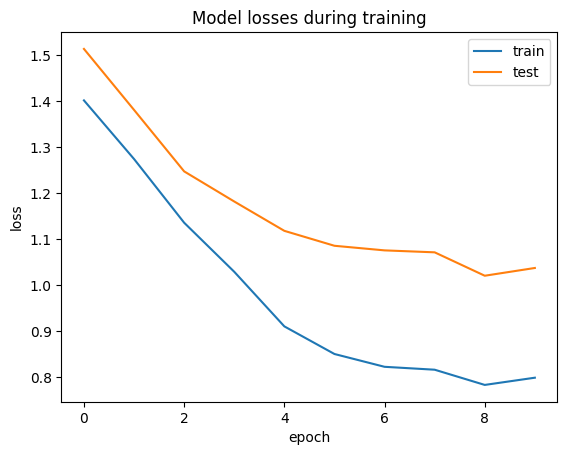

In [17]:
# Plot loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [19]:
test_ratings = {}
movie_ids = ['1681', '1457', '500', '838', 'xxx']
for movie_id in movie_ids:
  test_ratings[movie_id] = ranking_model({
      "user_id": np.array(["1"]),
      "movie_id": np.array([movie_id])
  })

print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

Ratings:
500: [[3.4644787]]
1681: [[3.3685417]]
1457: [[3.3685417]]
838: [[3.3685417]]
xxx: [[3.3685417]]
